In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle, islice
import gc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
import xgboost as xgb
import catboost as cb
import timeit
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, RepeatedKFold


In [3]:
data = pd.read_csv('/Users/anas/Downloads/fraud_data.csv')

In [4]:
%%time
def amount_oldbalanceOrg(row):
    if row['oldbalanceOrg'] - row['amount'] == 0:
        return 'equal'
    else: 
        return 'not equal'
    
def dest_transaction_error(row):
    if row['newbalanceDest'] - row['oldbalanceDest'] - row['amount'] != 0:
        return "error"
    else:
        return "no error"
    
def orig_transaction_error(row):
    if row['oldbalanceOrg'] - row['newbalanceOrig'] - row['amount'] != 0:
        return "error"
    else:
        return "no error"
    
def get_name_prefix(row):
    return row['nameOrig'][0] + '-' + row['nameDest'][0]

def transaction_duration(row):
    if row['step'] / 24 < 1:
        return 'less than one day'
    elif row['step'] / 168 < 1:
        return 'less than a week'
    elif row['step'] / 744 < 1:
        return 'less than a month' 
    else:
        return 'month'    
    
data['amount_oldbalanceOrg'] = data.apply(amount_oldbalanceOrg, axis = 1)
data['orig_transaction_error'] = data.apply(orig_transaction_error, axis = 1)    
data['dest_transaction_error'] = data.apply(dest_transaction_error, axis = 1)
data['orig_dest'] = data.apply(get_name_prefix, axis = 1)
data['transaction_duration'] = data.apply(transaction_duration, axis = 1)


CPU times: user 4min 12s, sys: 13.3 s, total: 4min 25s
Wall time: 4min 30s


In [5]:
def convert_columns_to_catg(df, column_list):
    for col in column_list:
        print("converting", col.ljust(30), "size: ", round(df[col].memory_usage(deep=True)*1e-6,2), end="\t")
        df[col] = df[col].astype("category")
        print("->\t", round(df[col].memory_usage(deep=True)*1e-6,2))

In [6]:
 convert_columns_to_catg(data, column_list=["amount_oldbalanceOrg","orig_transaction_error",
                                        "dest_transaction_error", "orig_dest",
                                        "transaction_duration"])

converting amount_oldbalanceOrg           size:  419.9	->	 6.36
converting orig_transaction_error         size:  395.8	->	 6.36
converting dest_transaction_error         size:  396.76	->	 6.36
converting orig_dest                      size:  381.76	->	 6.36
converting transaction_duration           size:  469.48	->	 6.36


In [7]:
trans_type = pd.DataFrame({'isFraud' : (data.groupby('type')['isFraud'].agg('sum') /8213) * 100,
             'count': (data['type'].value_counts()/data.shape[0]) * 100}).reset_index(level=0)

transaction_duration = pd.DataFrame({'isFraud' : (data.groupby('transaction_duration')['isFraud'].agg('sum') /8213) * 100,
            'count': (data['transaction_duration'].value_counts()/data.shape[0]) * 100}).reset_index(level=0)

orig_transaction_error = pd.DataFrame({'isFraud' : (data.groupby('orig_transaction_error')['isFraud'].agg('sum') /8213) * 100,
             'count': (data['orig_transaction_error'].value_counts()/data.shape[0]) * 100}).reset_index(level=0)

amount_oldbalanceOrg = pd.DataFrame({'isFraud' : (data.groupby('amount_oldbalanceOrg')['isFraud'].agg('sum') /8213) * 100,
            'count': (data['amount_oldbalanceOrg'].value_counts()/data.shape[0]) * 100}).reset_index(level=0)

dest_transaction_error = pd.DataFrame({'isFraud' : (data.groupby('dest_transaction_error')['isFraud'].agg('sum') /8213) * 100,
             'count': (data['dest_transaction_error'].value_counts()/data.shape[0]) * 100}).reset_index(level=0)

orig_dest = pd.DataFrame({'isFraud' : (data.groupby('orig_dest')['isFraud'].agg('sum') /8213) * 100,
             'count': (data['orig_dest'].value_counts()/data.shape[0]) * 100}).reset_index(level=0)

In [8]:

print('Fraud transaction = {}'.format((data[data['isFraud'] == 1].shape[0] / data.shape[0])*100))
print('Not Fraud transaction = {}'.format((data[data['isFraud'] == 0].shape[0] / data.shape[0])*100))

Fraud transaction = 0.12908204481801522
Not Fraud transaction = 99.87091795518198


In [9]:
flag = pd.DataFrame({'isFraud' : (data.groupby('isFlaggedFraud')['isFraud'].agg('sum') /data['isFlaggedFraud'].value_counts()) * 100,
             'count': (data['isFlaggedFraud'].value_counts()/data.shape[0]) * 100}).reset_index(level=0)
flag

,index,isFraud,count
0,0,0.128831,99.999749
1,1,100.000000,0.000251


In [10]:
flag['isFraud'].to_list()

[0.12883090005287143, 100.0]

/Users/anas/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='type', ylabel='count'>

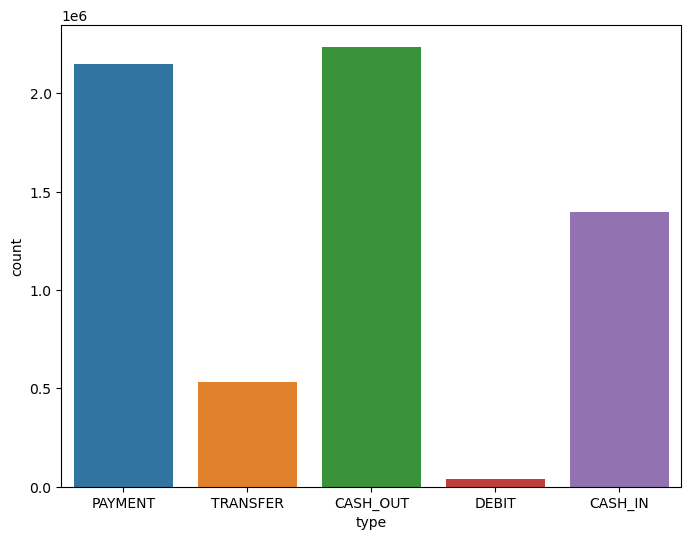

In [11]:
fig_dims = (8, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data['type'])

<AxesSubplot:xlabel='index', ylabel='isFraud'>

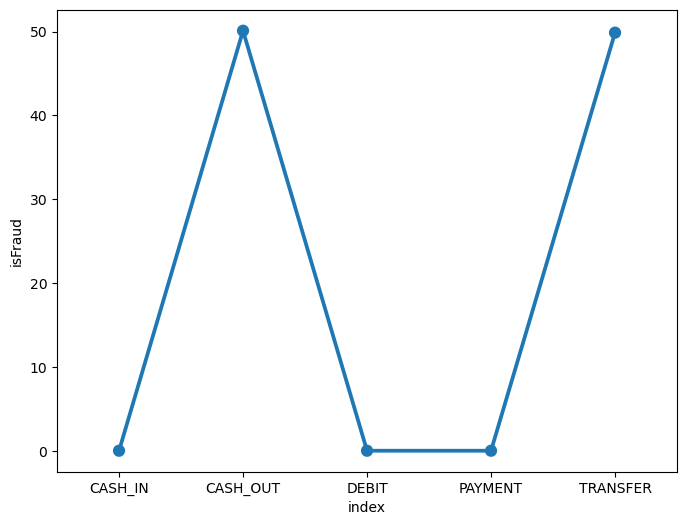

In [12]:
fig_dims = (8, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.pointplot(x='index',y='isFraud',data=trans_type)

In [13]:
trans_type['count'].to_list()

[21.992261049693365,
 35.16633085112736,
 0.6511782881894566,
 33.81460781879163,
 8.375621992198184]

/Users/anas/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='orig_dest', ylabel='count'>

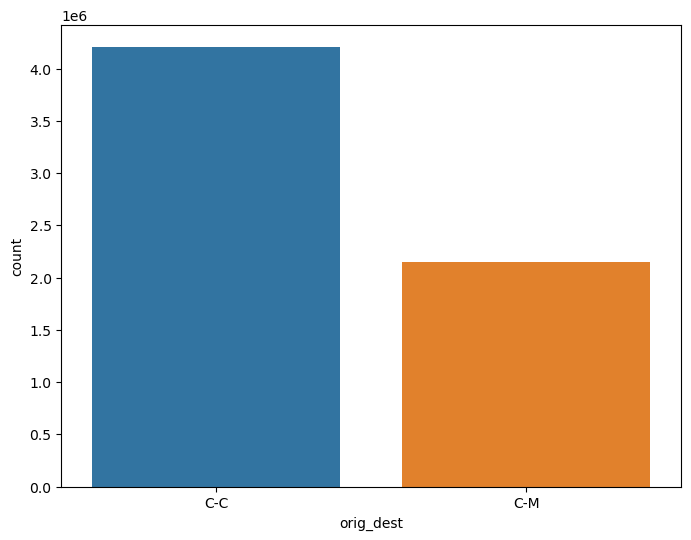

In [14]:
fig_dims = (8, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data['orig_dest'])

/Users/anas/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='orig_transaction_error', ylabel='count'>

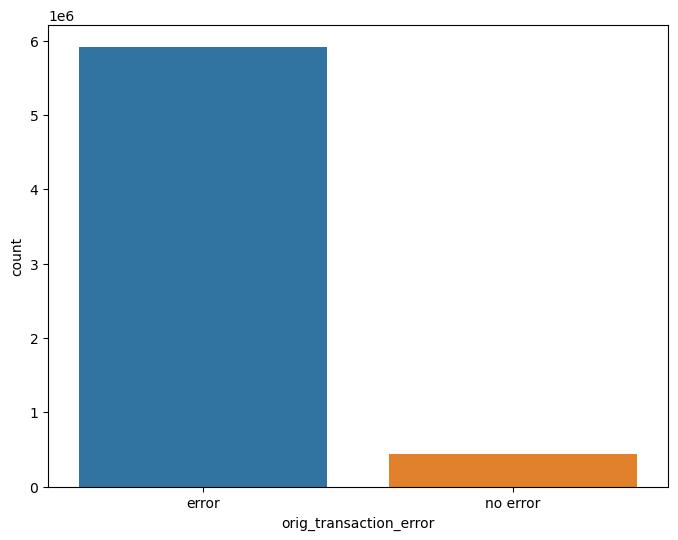

In [15]:
fig_dims = (8, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data['orig_transaction_error'])

<AxesSubplot:xlabel='index', ylabel='isFraud'>

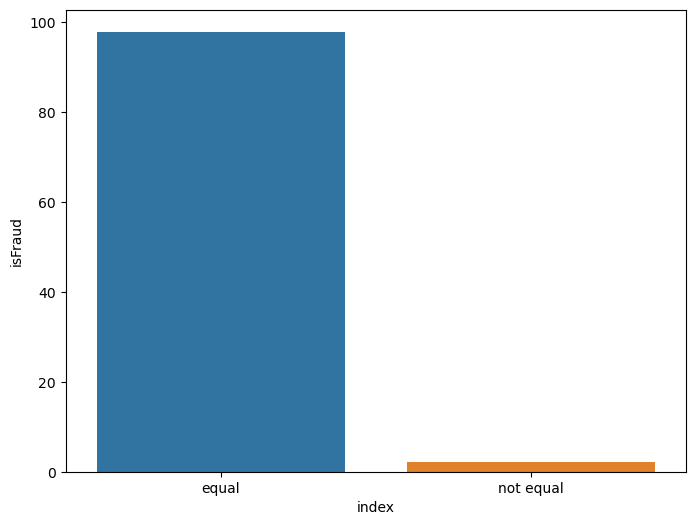

In [16]:
fig_dims = (8, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x = 'index',
            y = 'isFraud',
            data = amount_oldbalanceOrg)

Data Cleaning

In [17]:
# remove useless rows and columns
data = data[data['orig_dest'] == "C-C"]
data = data[(data['type'] == "CASH_OUT") | (data['type'] == "TRANSFER")]
data.shape

(2770409, 16)

In [18]:
print('Fraud transaction = {}'.format((data[data['isFraud'] == 1].shape[0] / data.shape[0])*100))
print('Not Fraud transaction = {}'.format((data[data['isFraud'] == 0].shape[0] / data.shape[0])*100))

Fraud transaction = 0.2964544224336551
Not Fraud transaction = 99.70354557756635


In [19]:
data = data.drop([ 'amount_oldbalanceOrg',
       'orig_transaction_error', 'dest_transaction_error', 'orig_dest',
       'transaction_duration'],1)
data.shape

/var/folders/c1/z8f2t00s5jsbjfqrxfx_fg3w0000gn/T/ipykernel_40440/895750766.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop([ 'amount_oldbalanceOrg',


(2770409, 11)

In [20]:
train, test, train_target, test_target = train_test_split(
    data.drop("isFraud",1), data["isFraud"], test_size=0.3)

/var/folders/c1/z8f2t00s5jsbjfqrxfx_fg3w0000gn/T/ipykernel_40440/1502485523.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop("isFraud",1), data["isFraud"], test_size=0.3)


In [21]:
(train_target.value_counts() / train.shape[0])*100

0    99.703035
1     0.296965
Name: isFraud, dtype: float64

In [22]:
(test_target.value_counts()/ test.shape[0])*100

0    99.704737
1     0.295263
Name: isFraud, dtype: float64

Data Preprocessing

In [23]:
features = [col for col in train.columns if col not in ("Unnamed: 0", "nameOrig", "nameDest")]
cat_cols = [col for col in features if train[col].dtypes == np.object]

/var/folders/c1/z8f2t00s5jsbjfqrxfx_fg3w0000gn/T/ipykernel_40440/1990060516.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cat_cols = [col for col in features if train[col].dtypes == np.object]


In [24]:
encoder = OrdinalEncoder()
    
train[cat_cols] = encoder.fit_transform(train[cat_cols])
test[cat_cols] = encoder.transform(test[cat_cols])

In [25]:
X = train[features].values
Xtest = test[features].values
y = train_target.values 
ytest = test_target.values

Model Fitting

In [26]:
def metrics(yvalid, valid_preds):
    f1 = f1_score(yvalid, valid_preds)
    recall = recall_score(yvalid, valid_preds)
    precision = precision_score(yvalid, valid_preds)
    accuracy = accuracy_score(yvalid, valid_preds)
    return f1, recall, precision, accuracy

In [27]:
def run_model(cv, model,  key, req_features='' ):
    final_preds = []
    F1 = []
    Recall = []
    Precision = []
    Accuracy = []
    train_speed = 0
    test_speed = 0
    
    if key =='LOG':
        print('-' * 60)
        print("Start training Logistic Regression")
        print('-' * 60)    
        for i, (train_index, test_index) in enumerate(rkf.split(X)):
            X_train, X_val = X[train_index], X[test_index]
            y_train, y_val = y[train_index], y[test_index]
            test = Xtest.copy()
            
            print('Training')
            start = timeit.default_timer()
            model.fit(X_train,y_train)
            stop = timeit.default_timer()
            train_speed += stop - start

             
            print('Testing') 
            #Prediction session
            valid_preds = model.predict(X_val)
            conf_matrix = confusion_matrix(y_true=y_val, y_pred=valid_preds)
            print(conf_matrix)
            start = timeit.default_timer()
            test_preds = model.predict(Xtest)
            stop = timeit.default_timer()
            test_speed += stop - start
            print("Evaluate")
            final_preds.append(test_preds)
            #Performance evaluation
            f1, recall, precision, accuracy = metrics(y_val, valid_preds)
            F1.append(f1)
            Recall.append(recall)
            Precision.append(precision)
            Accuracy.append(accuracy)
            print("Fold {} ==> f1: {}, recall: {}, precision: {}, accuracy: {} \n".format(i + 1, f1, recall, precision, accuracy))
        print('-' * 30)
        print('Average F1 score: {}'.format(np.mean(F1)))
        print('Average Recall score: {}'.format(np.mean(Recall)))
        print('Average Precision score: {}'.format(np.mean(Precision)))
        print('Average Accuracy score: {}'.format(np.mean(Accuracy)))
        
    elif key =='RF':
        print('-' * 60)
        print("Start training Random Forest")
        print('-' * 60)    
        for i, (train_index, test_index) in enumerate(rkf.split(X)):
            X_train, X_val = X[train_index], X[test_index]
            y_train, y_val = y[train_index], y[test_index]
            test = Xtest.copy()
            
            print('Training')
            start = timeit.default_timer()
            model.fit(X_train,y_train)
            stop = timeit.default_timer()
            train_speed += stop - start

             
            print('Testing') 
            #Prediction session
            valid_preds = model.predict(X_val)
            conf_matrix = confusion_matrix(y_true=y_val, y_pred=valid_preds)
            print(conf_matrix)
            start = timeit.default_timer()
            test_preds = model.predict(Xtest)
            stop = timeit.default_timer()
            test_speed += stop - start
            print("Evaluate")
            final_preds.append(test_preds)
            #Performance evaluation
            f1, recall, precision, accuracy = metrics(y_val, valid_preds)
            F1.append(f1)
            Recall.append(recall)
            Precision.append(precision)
            Accuracy.append(accuracy)
            print("Fold {} ==> f1: {}, recall: {}, precision: {}, accuracy: {} \n".format(i + 1, f1, recall, precision, accuracy))
        print('-' * 30)
        print('Average F1 score: {}'.format(np.mean(F1)))
        print('Average Recall score: {}'.format(np.mean(Recall)))
        print('Average Precision score: {}'.format(np.mean(Precision)))
        print('Average Accuracy score: {}'.format(np.mean(Accuracy)))
    
    elif key =='CAT':
        print('-' * 60)
        print("Start training catboost")
        print('-' * 60)    
        for i, (train_index, test_index) in enumerate(rkf.split(X)):
            X_train, X_val = X[train_index], X[test_index]
            y_train, y_val = y[train_index], y[test_index]
            test = Xtest.copy()
            
            print('Training')
            start = timeit.default_timer()
            model.fit(X_train,y_train,
                     eval_set=(X_val, y_val),
                     use_best_model=True)
            stop = timeit.default_timer()
            train_speed += stop - start

             
            print('Testing') 
            #Prediction session
            valid_preds = model.predict(X_val)
            conf_matrix = confusion_matrix(y_true=y_val, y_pred=valid_preds)
            print(conf_matrix)
            start = timeit.default_timer()
            test_preds = model.predict(Xtest)
            stop = timeit.default_timer()
            test_speed += stop - start
            print("Evaluate")
            final_preds.append(test_preds)
            #Performance evaluation
            f1, recall, precision, accuracy = metrics(y_val, valid_preds)
            F1.append(f1)
            Recall.append(recall)
            Precision.append(precision)
            Accuracy.append(accuracy)
            print("Fold {} ==> f1: {}, recall: {}, precision: {}, accuracy: {} \n".format(i + 1, f1, recall, precision, accuracy))
        print('-' * 30)
        print('Average F1 score: {}'.format(np.mean(F1)))
        print('Average Recall score: {}'.format(np.mean(Recall)))
        print('Average Precision score: {}'.format(np.mean(Precision)))
        print('Average Accuracy score: {}'.format(np.mean(Accuracy)))
            
    else:
        print('-' * 60)
        print("Start training xgboost")
        print('-' * 60)    
        for i, (train_index, test_index) in enumerate(rkf.split(X)):
            X_train, X_val = X[train_index], X[test_index]
            y_train, y_val = y[train_index], y[test_index]
            test = Xtest.copy()
            
            print('Training')
            start = timeit.default_timer()
            model.fit(X_train,y_train)
            stop = timeit.default_timer()
            train_speed += stop - start

             
            print('Testing') 
            #Prediction session
            valid_preds = model.predict(X_val)
            conf_matrix = confusion_matrix(y_true=y_val, y_pred=valid_preds)
            print(conf_matrix)
            start = timeit.default_timer()
            test_preds = model.predict(Xtest)
            stop = timeit.default_timer()
            test_speed += stop - start
            print("Evaluate")
            final_preds.append(test_preds)
            #Performance evaluation
            f1, recall, precision, accuracy = metrics(y_val, valid_preds)
            F1.append(f1)
            Recall.append(recall)
            Precision.append(precision)
            Accuracy.append(accuracy)
            print("Fold {} ==> f1: {}, recall: {}, precision: {}, accuracy: {} \n".format(i + 1, f1, recall, precision, accuracy))
        print('-' * 30)
        print('Average F1 score: {}'.format(np.mean(F1)))
        print('Average Recall score: {}'.format(np.mean(Recall)))
        print('Average Precision score: {}'.format(np.mean(Precision)))
        print('Average Accuracy score: {}'.format(np.mean(Accuracy)))
    
    return model, final_preds, np.mean(F1), np.mean(Recall), np.mean(Precision), np.mean( Accuracy),train_speed, test_speed

In [28]:
rkf = RepeatedKFold(n_splits=2,n_repeats=2,random_state=21)

In [29]:

xgb_params = {"objective":"binary:logistic",
              "eval_metric":"logloss",
                "learning_rate":0.01,
                "max_depth":7,
                "min_child_weight":5,
                "colsample_bytree":0.5,
                "subsample":0.5,
                "n_estimators": 1000,
             "random_state":42,
              "use_label_encoder":False, 
              "verbosity" : 0}
catboost_params = {"loss_function":'Logloss',
                   "eval_metric":"Recall",  
                    "learning_rate":0.01,
                    "depth":5,
                    "iterations":1000,
                     "silent":True,
                  }

In [30]:
model_lr_def = LogisticRegression(solver= "saga")
model_rf_def = RandomForestClassifier()
model_cat_def = cb.CatBoostClassifier(**catboost_params)
model_xgb_def = xgb.XGBClassifier(**xgb_params)

/Users/anas/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [31]:
model_lr, final_preds_lr, F1_lr, Recall_lr, Precision_lr, accuracy_lr, train_speed_lr, test_speed_lr = run_model(rkf, model_lr_def, key='LOG',req_features=features)
model_rf, final_preds_rf, F1_rf, Recall_rf, Precision_rf, accuracy_rf, train_speed_rf, test_speed_rf= run_model(rkf, model_rf_def, key='RF',req_features=features)
model_cat, final_preds_cat, F1_cat, Recall_cat, Precision_cat, accuracy_cat, train_speed_cat, test_speed_cat = run_model(rkf, model_cat_def, key='CAT',req_features=features)
model_xgb, final_preds_xgb, F1_xgb, Recall_xgb, Precision_xgb, accuracy_xgb, train_speed_xgb, test_speed_xgb = run_model(rkf, model_xgb_def,
                                                                                     key='XGB',
                                                                                     req_features=features)

------------------------------------------------------------
Start training Logistic Regression
------------------------------------------------------------
Training


/Users/anas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Testing
[[966429    355]
 [  2859      0]]
Evaluate
Fold 1 ==> f1: 0.0, recall: 0.0, precision: 0.0, accuracy: 0.9966853780205704 

Training


/Users/anas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Testing
[[966743      0]
 [  2900      0]]
Evaluate


/Users/anas/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 2 ==> f1: 0.0, recall: 0.0, precision: 0.0, accuracy: 0.997009208543763 

Training


/Users/anas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Testing
[[966809      0]
 [  2834      0]]
Evaluate


/Users/anas/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3 ==> f1: 0.0, recall: 0.0, precision: 0.0, accuracy: 0.9970772748320774 

Training


/Users/anas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Testing
[[966718      0]
 [  2925      0]]
Evaluate


/Users/anas/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 4 ==> f1: 0.0, recall: 0.0, precision: 0.0, accuracy: 0.9969834258587954 

------------------------------
Average F1 score: 0.0
Average Recall score: 0.0
Average Precision score: 0.0
Average Accuracy score: 0.9969388218138016
------------------------------------------------------------
Start training Random Forest
------------------------------------------------------------
Training
Testing
[[966740     44]
 [   677   2182]]
Evaluate
Fold 1 ==> f1: 0.8582104228121927, recall: 0.7632039174536551, precision: 0.9802336028751123, accuracy: 0.9992564273655355 

Training
Testing
[[966705     38]
 [   691   2209]]
Evaluate
Fold 2 ==> f1: 0.858364095589664, recall: 0.7617241379310344, precision: 0.9830885625278148, accuracy: 0.9992481769063459 

Training
Testing
[[966772     37]
 [   661   2173]]
Evaluate
Fold 3 ==> f1: 0.8616177636796193, recall: 0.7667607621736062, precision: 0.9832579185520361, accuracy: 0.9992801474357057 

Training
Testing
[[966674     44]
 [   704   2221]]
Evaluate


In [32]:
print("train_speed: {}".format(train_speed_xgb))
print("test_speed: {}".format(test_speed_xgb))

train_speed: 819.881095792
test_speed: 11.666519625999854


In [34]:
lm_predict = np.max(np.column(final_preds_lr),axis=1)

AttributeError: module 'numpy' has no attribute 'column'

# Best fit model details 

<AxesSubplot:>

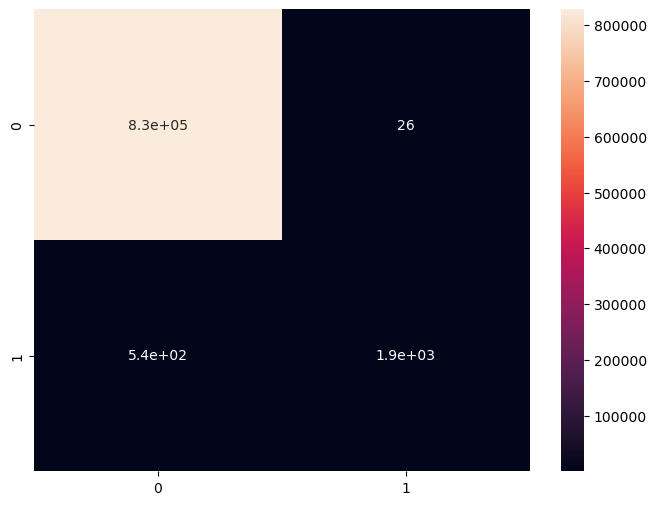

In [35]:
preds = np.max(np.column_stack(final_preds_xgb), axis=1)
conf_matrix = confusion_matrix(y_true=ytest, y_pred=preds)
fig_dims = (8, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(conf_matrix, annot=True)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.998


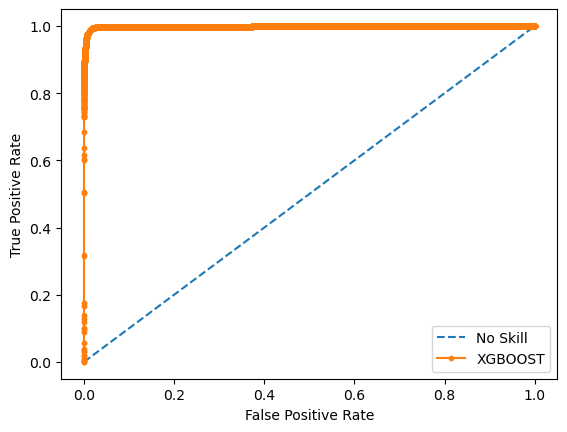

In [41]:
xgb_fit = model_xgb.fit(X_train,y_train)

NameError: name 'X_train' is not defined

In [42]:
f1, recall, precision, accuracy = metrics(ytest, preds)
print('Average F1 score: {}'.format(np.mean(f1)))
print('Average Recall score: {}'.format(np.mean(recall)))
print('Average Precision score: {}'.format(np.mean(precision)))
print('Average Accuracy score: {}'.format(np.mean(accuracy)))

Average F1 score: 0.8724710161400318
Average Recall score: 0.7819885900570497
Average Precision score: 0.9866323907455012
Average Accuracy score: 0.9993250096556106


In [43]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, auc
import matplotlib.pyplot as plt

In [44]:
test_pred_3 = model_xgb_def.predict(Xtest)

In [45]:
test_pred_1 = model_lr_def.predict(Xtest)

In [46]:
test_pred_2 = model_rf_def.predict(Xtest)

In [47]:
print("=== All AUC Scores ===")
fpr_lm,recall_lm,thresholds_lm = roc_curve(ytest, test_pred_1)
auc_lm=auc(fpr_lm, recall_lm)
print('AUC: %.2f' % auc_lm)

=== All AUC Scores ===
AUC: 0.50


In [ ]:
# calculate AUC
auc = roc_auc_score(y, probs)
print('AUC: %.3f' % auc)

In [39]:
ns_probs = [0 for _ in range(len(ytest))]

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.659


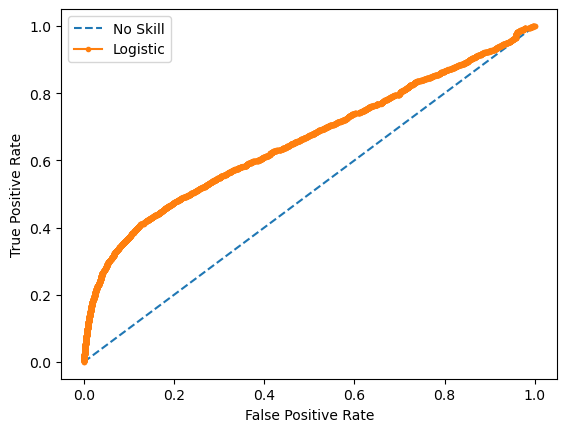

In [48]:
# predict probabilities
lr_probs = model_lr_def.predict_proba(Xtest)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(ytest, ns_probs)
lr_auc = roc_auc_score(ytest, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(ytest, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(ytest, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.988


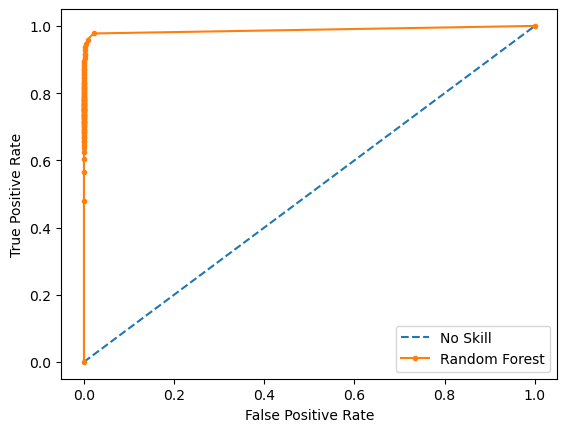

In [49]:
# predict probabilities
rf_probs = model_rf_def.predict_proba(Xtest)
# keep probabilities for the positive outcome only
rf_probs = rf_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(ytest, ns_probs)
rf_auc = roc_auc_score(ytest, rf_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (rf_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(ytest, ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(ytest, rf_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

No Skill: ROC AUC=0.500
XGBoost: ROC AUC=0.998


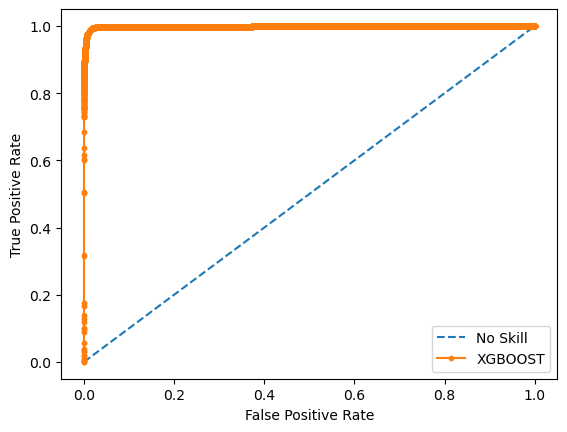

In [50]:
# predict probabilities
xgb_probs = model_xgb_def.predict_proba(Xtest)
# keep probabilities for the positive outcome only
xgb_probs = xgb_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(ytest, ns_probs)
xgb_auc = roc_auc_score(ytest, xgb_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGBoost: ROC AUC=%.3f' % (xgb_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(ytest, ns_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(ytest, xgb_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGBOOST')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Model Comparision Plot

  Model  Accuracy  Precision  Recall  F1-Score
0    LR     99.60       0.00    0.00      0.00
1    RF     99.99      98.17   76.27     85.85
2   XGB     99.92      98.06   74.74     86.36
3   CAT     99.99      98.06   74.74     84.82


<AxesSubplot:title={'center':'Model Comparision using original data'}, xlabel='Model'>

<Figure size 1000x1000 with 0 Axes>

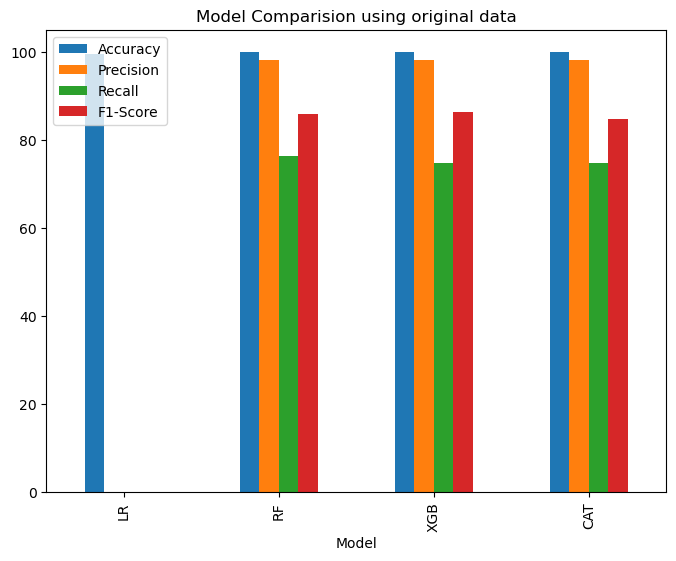

In [51]:
# create data
df = pd.DataFrame([['LR', 99.6, 0, 0, 0], ['RF', 99.99, 98.17, 76.27, 85.85],
                  ['XGB', 99.92, 98.06, 74.74, 86.36 ], ['CAT', 99.99, 98.06, 74.74, 84.82]],
                  columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
# view data
print(df)
  
# plot grouped bar chart
plt.figure(figsize=(10,10))
df.plot(x='Model',
        kind='bar',
        figsize=(8,6),
        stacked=False,
        title='Model Comparision using original data')